In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../api_fetcher/cleaned_abstracts.csv')
df

,abstracts
0,We modulated a solvent-mediated adduct for one...
1,The device performance is enhanced by doping a...
2,Lead halide perovskites have emerged as succes...
3,Several applications of perovskite solar cells...
4,High temperature stable inorganic CsPbX3 (X: I...
...,...
3364,Resonant semiconductor nanoparticles (NPs) tha...
3365,A rutile TiO2 nanodendrite array (3D-RTNDA) co...
3366,A perovskite solar cell with an inverted p–i–n...
3367,"Fullerene derivatives, especially after purpos..."


In [10]:
abstracts = df['abstracts'].tolist()
embedding = np.load("encoded_data.npy")



In [ ]:
abstracts

In [35]:
for i,abstract in enumerate(abstracts[:5]):
    if isinstance(abstract, list):
        print(f"abstracts{i} is a list :{abstracts}")

In [ ]:
embedding[0]

In [ ]:
embedding_map = {abstracts: embedding for abstract, embedding in zip(abstracts,embedding)}

In [52]:
embedding_map = dict(zip(abstracts, embedding))

In [55]:
def get_embedding(text):
    return embedding_map.get(text, None)

In [ ]:
get_embedding(abstracts[1])

In [ ]:
print(first_abstract)  # "This is the first abstract."
print(first_embedding)

In [57]:
import pickle

with open("embedding_map.pkl","wb") as f:
    pickle.dump(embedding_map,f)

In [ ]:
embedding[1]

In [22]:
text = abstracts[1]
embedding_test = embedding_map.get(text, None)

if embedding_test is not None:
    print("embedding found")
else :
    print("did sadfasdf") 

did sadfasdf


In [26]:
first_text, first_embedding = next(iter(embedding_map.items()))

In [ ]:
first_text, first_embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import itertools
df_list = df['abstracts'].tolist()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_list)

tfidf_matrix.shape


from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [6]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
embeddings = model.encode(df_list, show_progress_bar=True)  # Returns a list of sentence embeddings

In [17]:
import numpy as np 
embeddings = np.load("stella_encoded_data.npy")

In [18]:
embeddings.shape

(3369, 1024)

In [ ]:
!pip install hdbscan
!pip install umap-learn

In [23]:
# we have to change from this cell goes on because we already have the embedding 
import umap
import hdbscan 
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return umap_embeddings, clusters.labels_ , clusters
    # return umap_embeddings, clusters

In [24]:
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering

umap_embeddings, cluster_labels,clusters = generate_clusters (embeddings,14,4,14)

In [41]:
import matplotlib.pyplot as plt
def visualize_clusters(umap_embeddings, cluster_labels):

    plt.figure(figsize=(10, 8))
    

    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                          c=cluster_labels, cmap='Spectral', s=50, alpha=0.7)

    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title("UMAP Clustering Visualization")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter)
    plt.show()

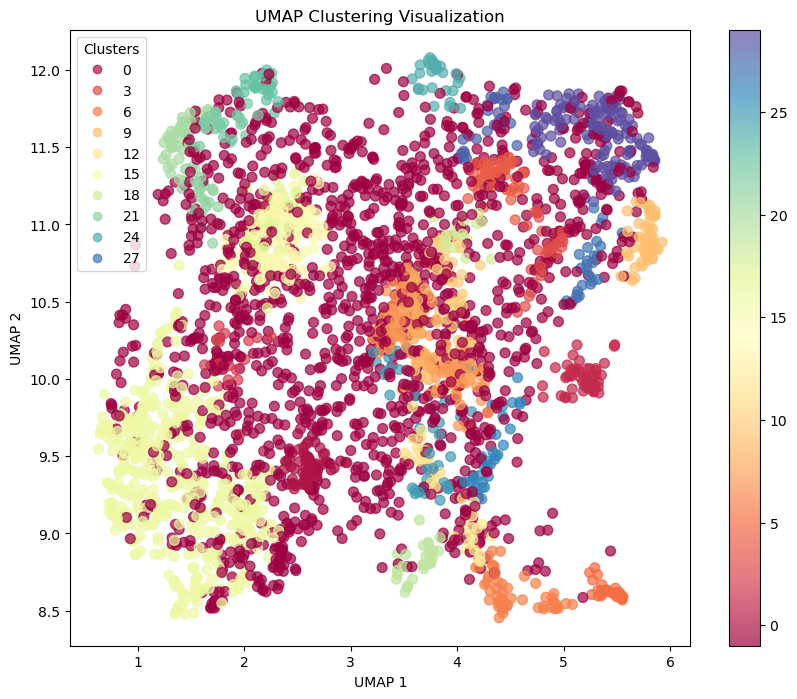

In [42]:
visualize_clusters(umap_embeddings, cluster_labels)

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
print(silhouette_avg)

0.12799549


In [14]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(umap_embeddings, cluster_labels)
print(f"Davies-Bouldin Index: {db_score}")


Davies-Bouldin Index: 0.9564043108966687


In [37]:
import numpy as np
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [38]:
result = score_clusters (clusters)
print(result)

(31, 0.44761056693380824)


In [39]:
import random
def random_search(embeddings, space, num_evals):
    """
    Randomly search hyperparameter space and limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        umap_embeddings, cluster_labels,clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [ ]:
# let's check different posibilities for getting least loss and find the hyper parameter 
space = {
    "n_neighbors" : range(12,16),
    "n_components" : range(3,7),
    "min_cluster_size" : range(2,16),
    "random_state" : 42
}

random_use = random_search(umap_embeddings,space,50)



In [65]:
random_use.head(40)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
32,32,14,4,14,58,0.098546
16,16,14,4,13,64,0.108934
45,45,12,5,14,56,0.110419
33,33,13,5,7,141,0.110715
17,17,12,3,11,79,0.111012
9,9,14,6,10,83,0.111012
24,24,14,4,12,67,0.112496
26,26,12,6,9,100,0.112793
11,11,14,3,10,88,0.113980
31,31,14,3,10,88,0.113980


In [83]:
print(clusters)

HDBSCAN(min_cluster_size=14)


In [86]:
print(len(cluster_labels))

3369


In [ ]:
abstracts = df_list
df = pd.DataFrame({'abstracts': abstracts, 'cluster': cluster_labels})

clustered_topic = {}
for cluster_label in df['cluster'].unique():
    clustered_topic[cluster_label] = df[df['cluster'] == cluster_label]['abstracts'].tolist()

# Now you can manually inspect each topic
for cluster, abstracts in clustered_topic.items():
    print(f"\nCluster {cluster} ({len(abstracts)} abstracts):")
    for abstract in abstracts[:10]:  # Show only the first 10 messages for brevity
        print(f"- {abstract}")

In [88]:
print(len(clustered_messages))

34


In [91]:
# save to csv 

df_sorted = df.sort_values(by='cluster')

# Save the result to a CSV file
df_sorted.to_csv("clustered_abstracts.csv", index=False)